# Imports

## Libraries

In [209]:
# Regular Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
%matplotlib inline


# Models
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# CV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import KFold

# Model Prep
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve


# Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
from regression_diagnostics import RegressionDiagnostics

# Statistics
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler

# Deployment
import pickle



# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## Data

In [210]:
# Import Data through Lib
from sklearn.datasets import load_boston

# Loading Data
boston=load_boston()

# Checking description of the dataset
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [211]:
# Let's convert this data and keep it in df format
df = pd.DataFrame(boston.data,columns=boston.feature_names)

# Add Target
df['Price']=boston.target

# Check - Head
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# EDA

## Info

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  Price    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


## Memory Optimization

In [213]:
def optimizeDT(data):
    
    ### Calculate Total Memory Consumtion Before the Optimization
    beforeOptimizer = {}
    afterOptimizer = {}
    reduction = {}
    
    ### Data Type Bucketing
    int_bucket = data.select_dtypes(include=['int64']).columns.tolist()
    float_bucket = data.select_dtypes(include=['float64']).columns.tolist()
    
    for col in data.columns:
        
        col_dt  =  str(data[col].dtypes)
        col_mem = data[col].memory_usage(deep=True)
        beforeOptimizer[col] = [col_dt, col_mem]
        
        if 'int' in col_dt:
            ### Optimize the Integer Data Type
            if col in int_bucket:
                data[col] = pd.to_numeric(data[col], downcast='integer')
                new_col_dt = str(data[col].dtypes)
                new_col_mem = data[col].memory_usage(deep=True)
                afterOptimizer[col] = [new_col_dt, new_col_mem]
                mem_diff = (beforeOptimizer.get(col)[1] - afterOptimizer.get(col)[1])
                reduction[col] = mem_diff
                
        elif 'float' in col_dt:
            ### Optimize the Floats
            if col in float_bucket:
                data[col] = pd.to_numeric(data[col], downcast='float')
                new_col_dt = str(data[col].dtypes)
                new_col_mem = data[col].memory_usage(deep=True)
                afterOptimizer[col] = [new_col_dt, new_col_mem]
                mem_diff = (beforeOptimizer.get(col)[1] - afterOptimizer.get(col)[1])
                reduction[col] = mem_diff
        
        elif 'object' in col_dt:
            
            ### Optimize the Object
            
            # Calculate the unique value in the column
            uni_val = len(data[col].unique())
            
            # Calculate the Total Value
            tot_val = len(data[col])
            
            # Condition
            if (uni_val / tot_val) < 0.5:
                data[col] = data[col].astype('category')
                new_col_dt = str(data[col].dtypes)
                new_col_mem = data[col].memory_usage(deep=True)
                afterOptimizer[col] = [new_col_dt, new_col_mem]
                mem_diff = (beforeOptimizer.get(col)[1] - afterOptimizer.get(col)[1])
                reduction[col] = mem_diff
            else:
                new_col_dt = str(data[col].dtypes)
                new_col_mem = data[col].memory_usage(deep=True)
                afterOptimizer[col] = [new_col_dt, new_col_mem]
                mem_diff = (beforeOptimizer.get(col)[1] - afterOptimizer.get(col)[1])
                reduction[col] = mem_diff
        else:
            pass
    
    

    ### Build Comparison Report Table
    
    # Set Up Before Table
    bdf = pd.DataFrame(beforeOptimizer).T
    bdf.columns = ['Default DT', 'Default Memory Consumption']
    
    # Set Up After Table
    adf = pd.DataFrame(afterOptimizer).T
    adf.columns = ['Optimized DT', 'Optimized Memory Consumption']
    
    # Set up 
    rdf = pd.DataFrame(reduction, index=[0]).T
    rdf.columns = ['Reduction']
    
    ### Concat DataFrame
    mem_util = pd.concat([bdf, adf, rdf], axis=1)
    
    ### Reduction %
    mem_util['Reduction %'] = mem_util['Reduction'] / mem_util['Default Memory Consumption'] * 100
    
    
    return mem_util

In [214]:
# check
#optimizeDT(df)

In [215]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  Price    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


## Summary Set

In [216]:
def extractNumCol(data):
    num_df = data.select_dtypes(include=['number'])
    num_col=list(num_df.columns)
    return num_col

In [217]:
def summarySet(data):
    
    
    """
    
    This Function is replica of Summary Table that present in Pandas.
    It way provide Summary Statistics for Numerical Columns
    
    """
    
    ### Extracting Only Numerical Columns
    numCols = extractNumCol(data)
    
    ### Save DataFrame
    summaryInfo = pd.DataFrame(data=['Count', 'Sum', 'Mean', 'STD', 'Min', '25th Percentile', '50th Percentile', 
                                     '75th Percentile', 'Max'], columns=['STAT'])
    
    for col in numCols:
    
        # Save Results in Dictionary
        result = dict()


        # Count
        count = data[col].count()
        result['Count'] = count

        # sum
        sum_val = data[col].sum()
        result['Sum'] = sum_val

        # Mean
        mean = round(data[col].mean(),2)
        result['Mean'] = mean

        # Min
        min_value = data[col].min()
        result['Min'] = min_value
        
        # Std
        std_value = data[col].std()
        result['STD'] = std_value

        # 25th Percentile
        percentile_25 = data[col].quantile(0.25)
        result['25th Percentile'] = percentile_25

        # 50th Percentile
        percentile_50 = data[col].quantile(0.50)
        result['50th Percentile'] = percentile_50

        # 75th Percentile
        percentile_75 = data[col].quantile(0.75)
        result['75th Percentile'] = percentile_75

        # Max
        max_val = data[col].max()
        result['Max'] = max_val

        # DF
        summaryDF = pd.DataFrame(result.items(), columns=['STAT', col])
        
    
        # Merge
        summaryInfo = summaryInfo.merge(summaryDF, on='STAT', how='left')
        
    return summaryInfo

In [218]:
# Check
summarySet(df)

,STAT,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,Count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
1,Sum,1828.442920,5750.000000,5635.210000,35.000000,280.675700,3180.025000,34698.900000,1920.291600,4832.000000,206568.000000,9338.500000,180477.060000,6402.450000,11401.600000
2,Mean,3.610000,11.360000,11.140000,0.070000,0.550000,6.280000,68.570000,3.800000,9.550000,408.240000,18.460000,356.670000,12.650000,22.530000
3,STD,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
4,Min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
5,25th Percentile,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
6,50th Percentile,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
7,75th Percentile,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
8,Max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Univariate Analysis

In [219]:
def uni_plots(data, col_name):
    fig, ax = plt.subplots(1, 3, figsize=(28, 8), squeeze=False)
    sns.histplot(data, x=col_name,ax=ax[0][0])
    sns.kdeplot(data[col_name], shade=True, ax=ax[0][1])
    sns.ecdfplot(data, x=col_name, ax=ax[0][2]);

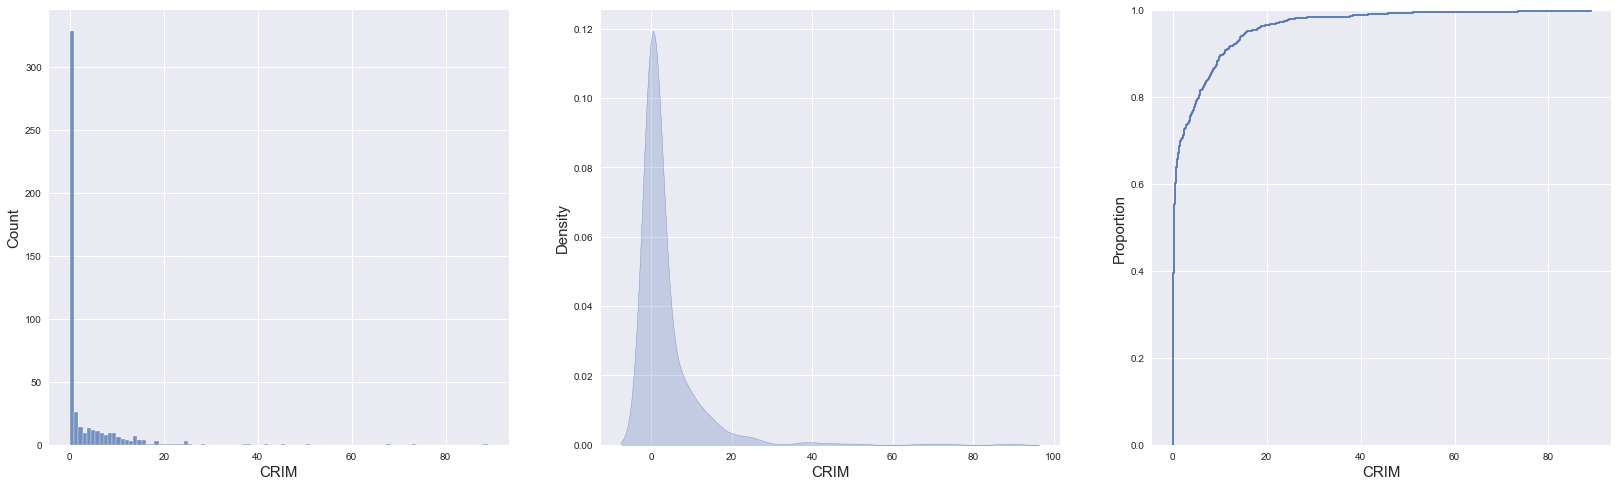

In [220]:
# check
uni_plots(df, 'CRIM')

In [221]:
def univariate_plots(data):
    
    
    """
    
    Univariate Analysis -
    This function prints the univariate plots of all numeric columns
    
        
    """
    
    ### Extract NumCols
    numCols = extractNumCol(data)
    
    for nc in numCols:
        fig, ax = plt.subplots(1, 3, figsize=(28, 8), squeeze=False)
        sns.histplot(data, x=nc,ax=ax[0][0])
        sns.kdeplot(data[nc], shade=True, ax=ax[0][1])
        sns.ecdfplot(data, x=nc, ax=ax[0][2]);

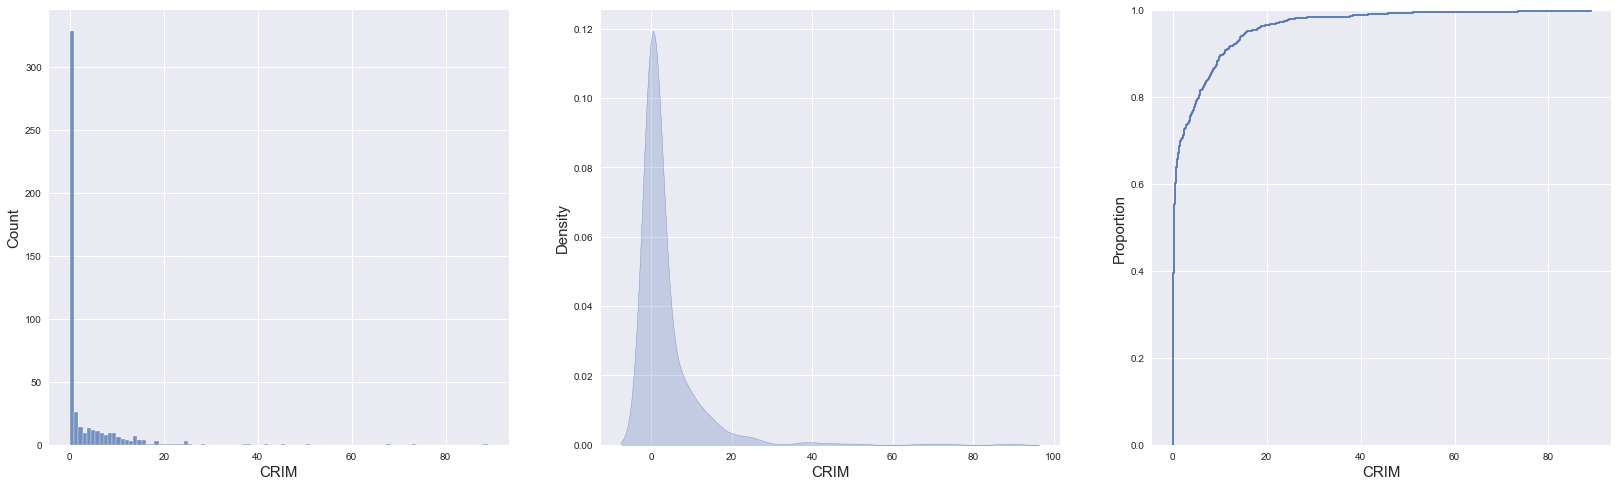

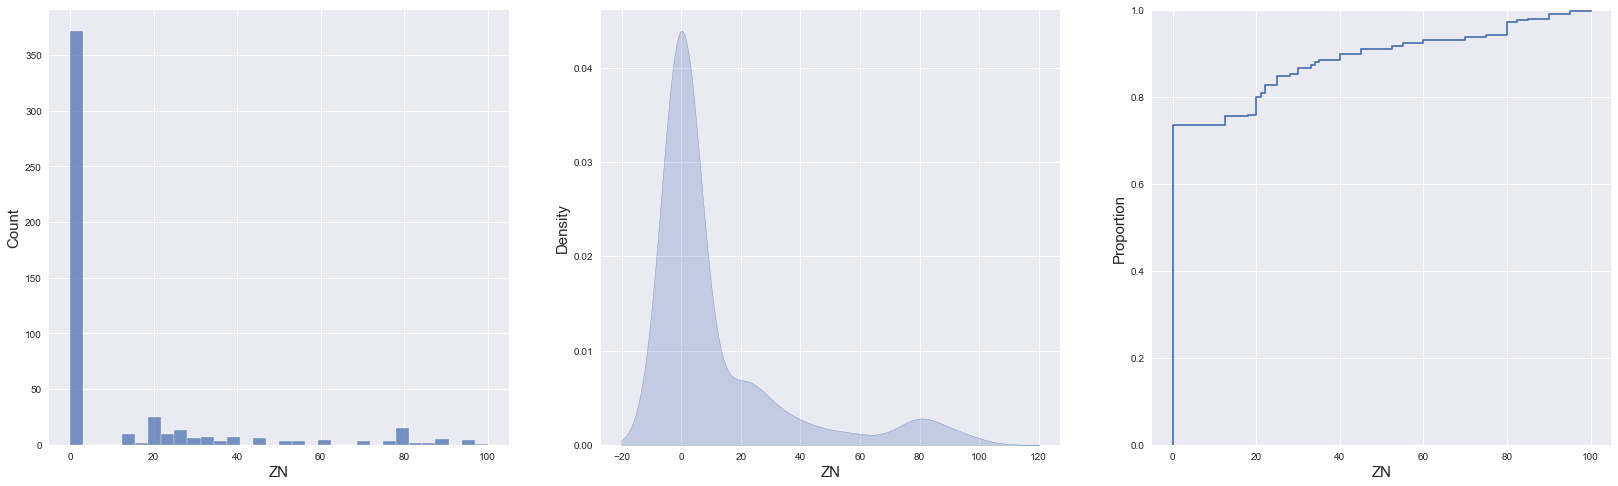

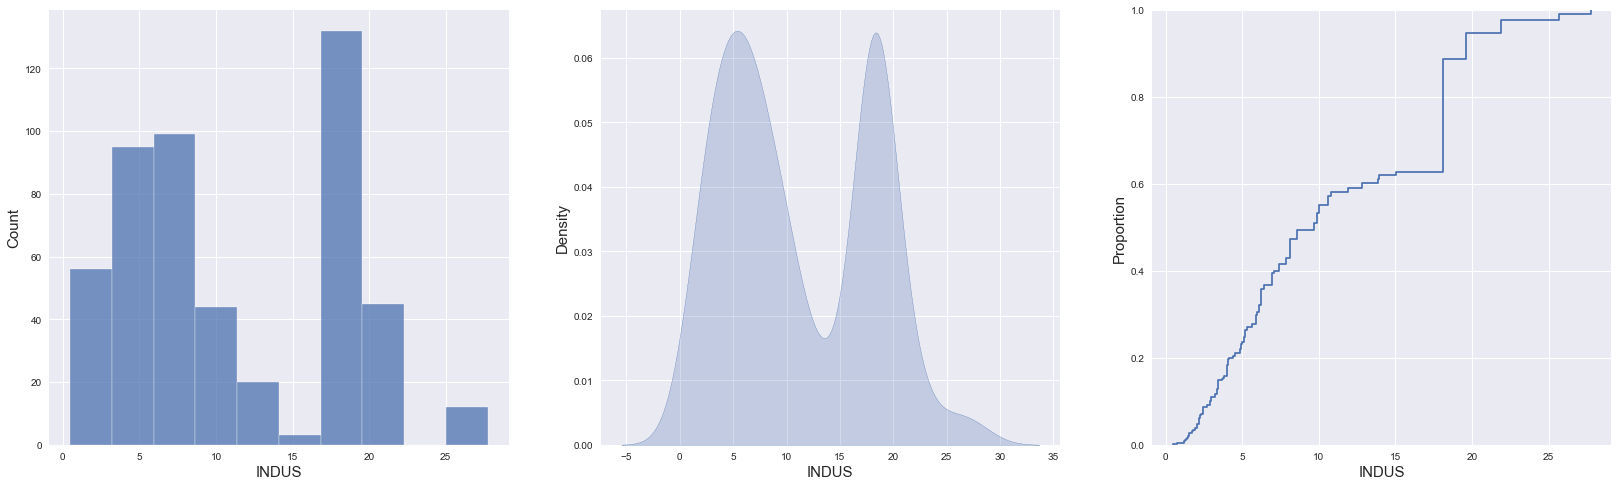

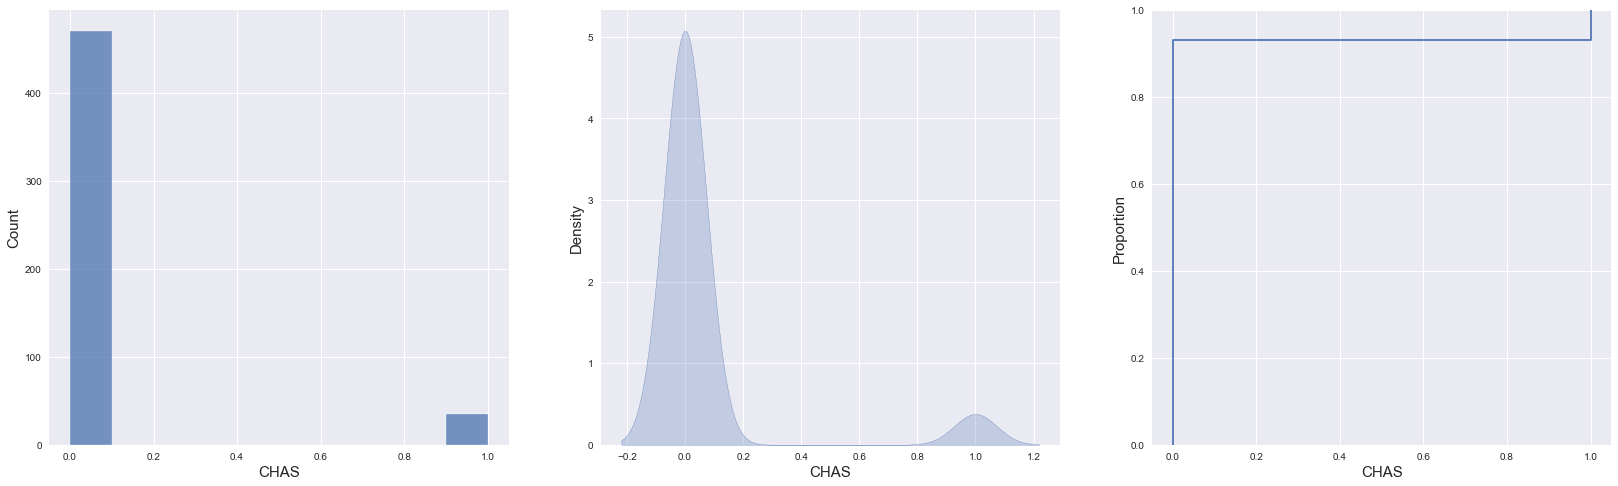

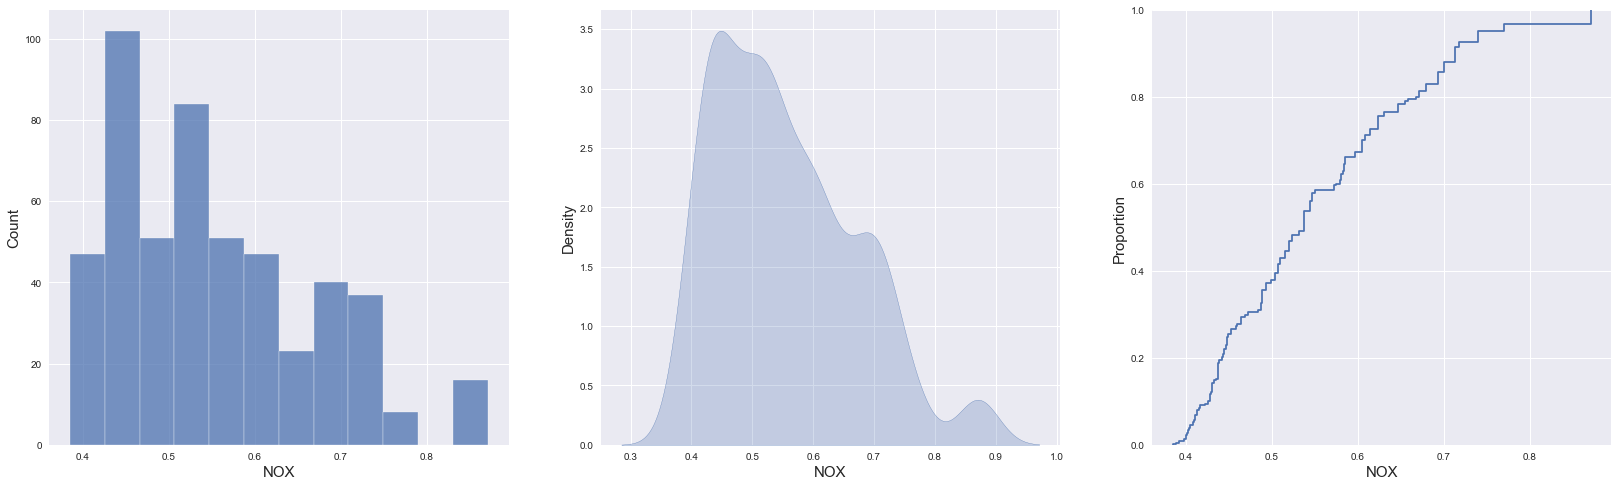

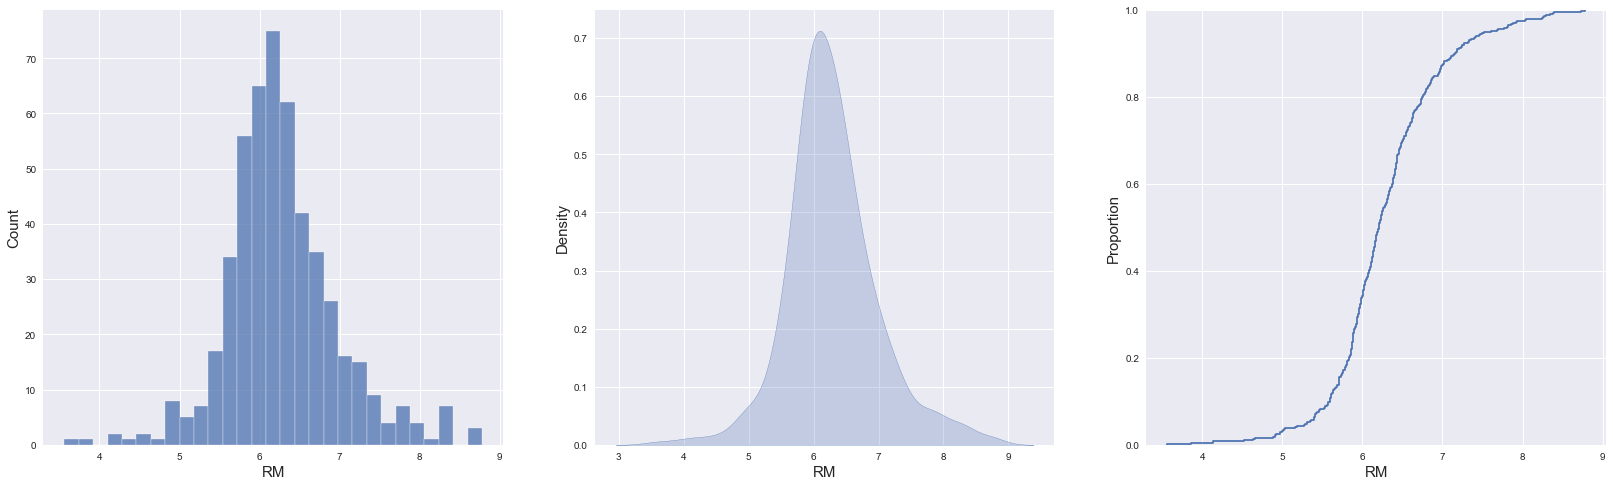

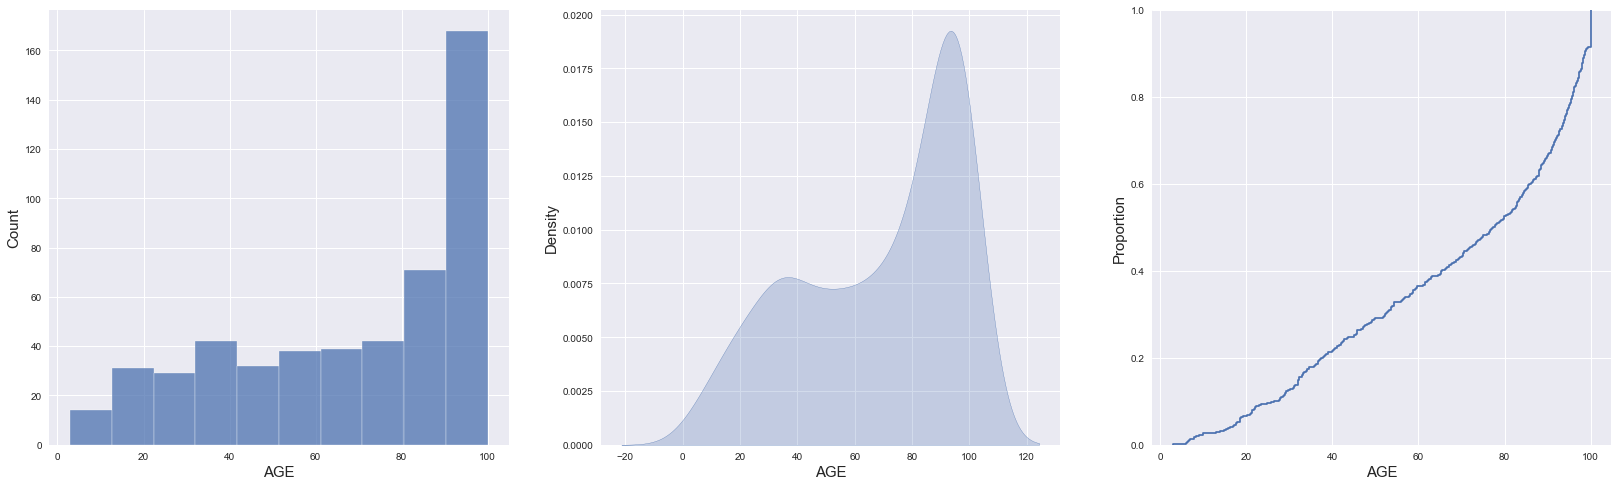

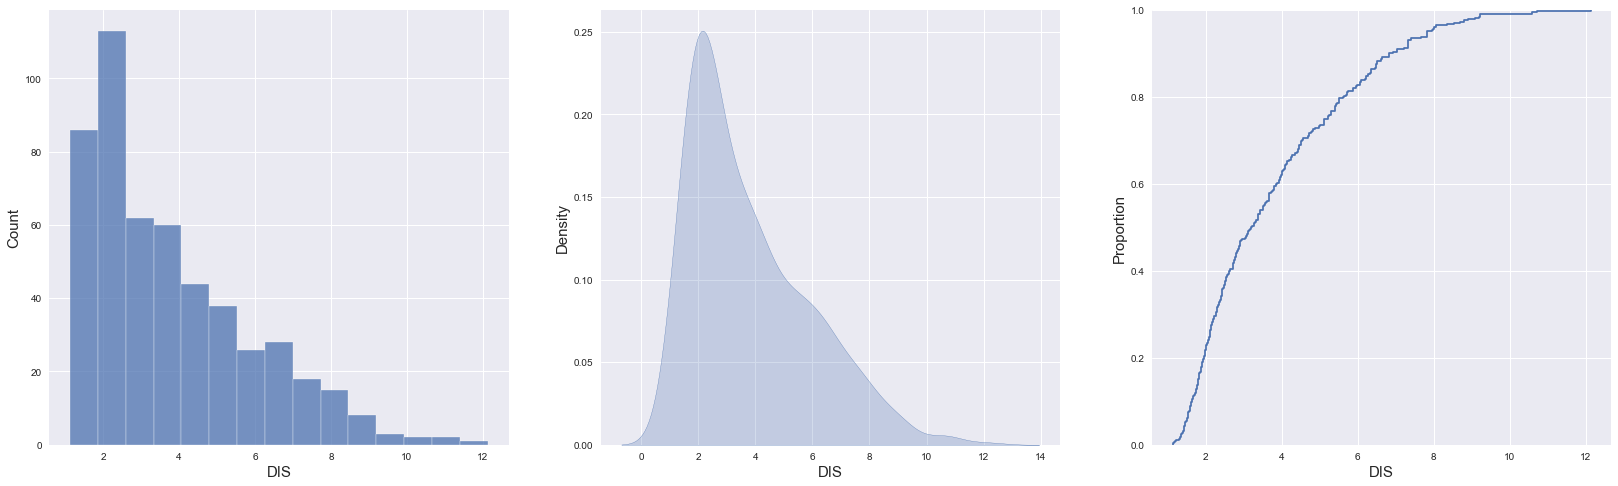

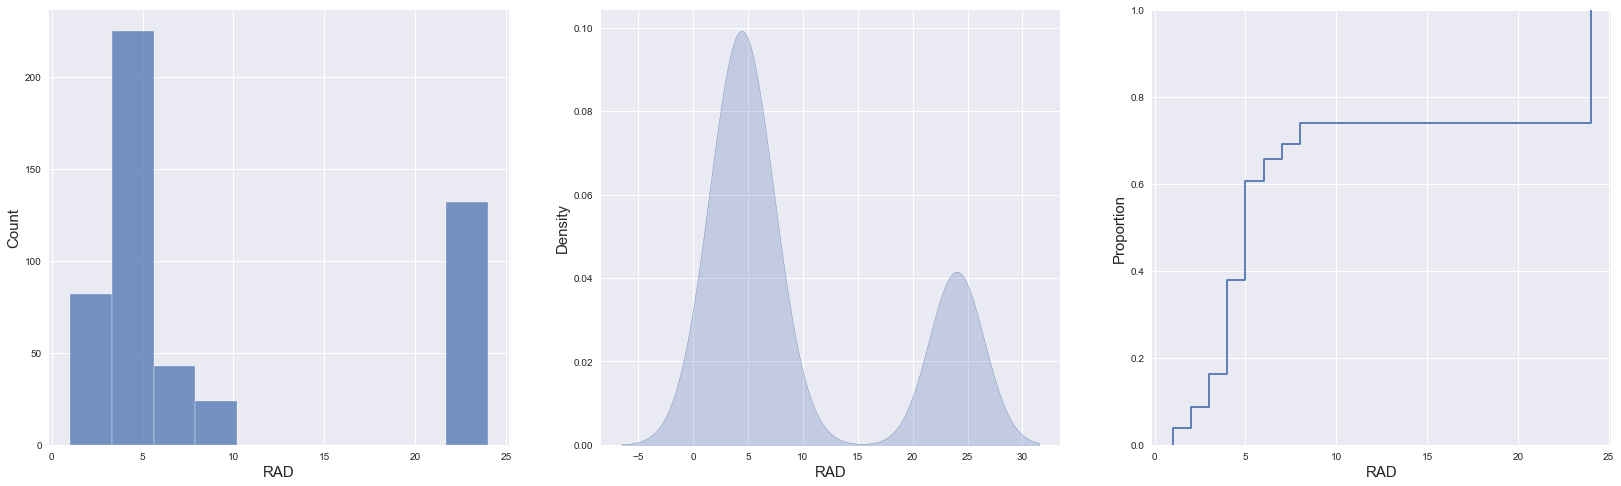

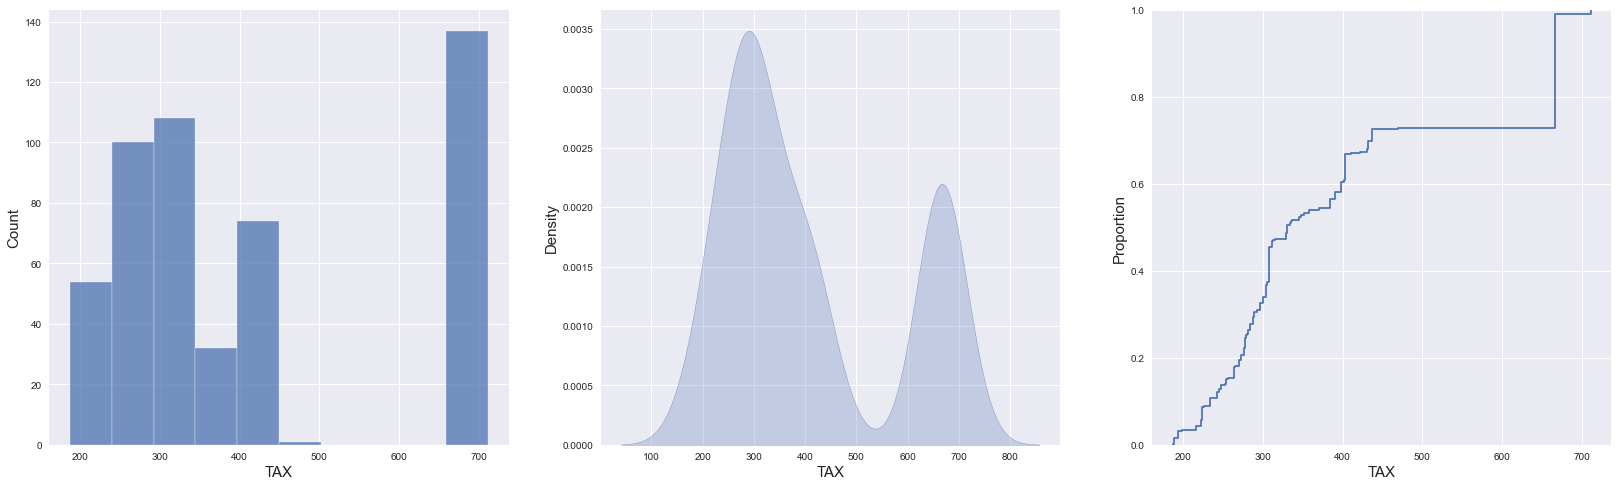

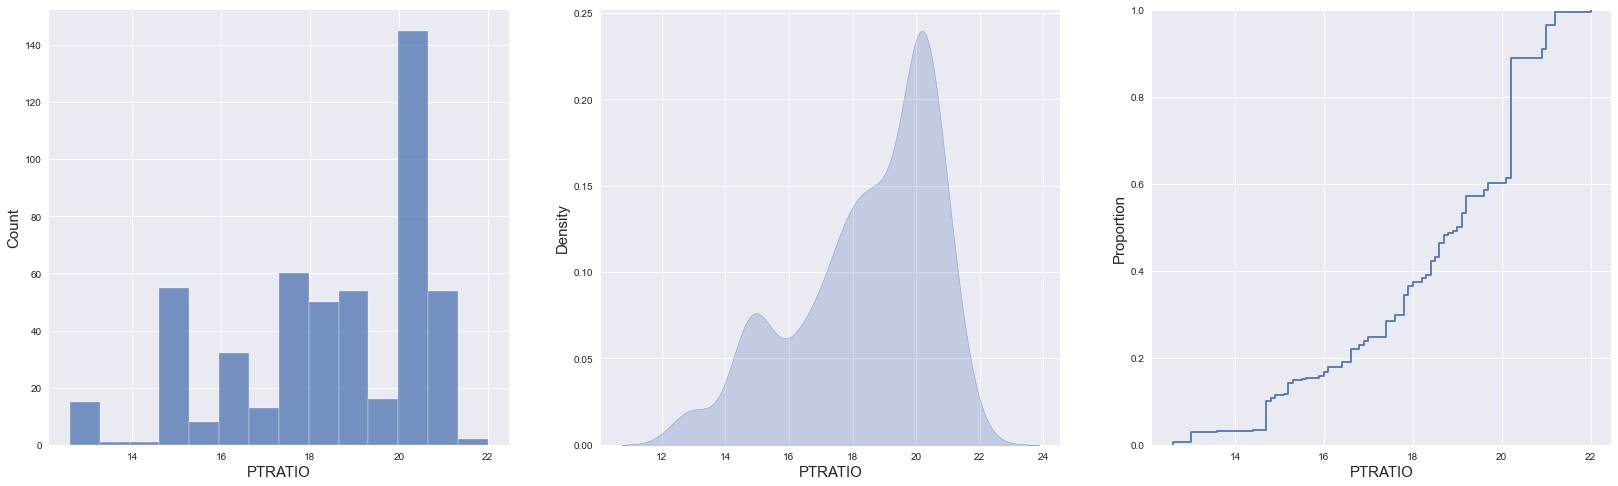

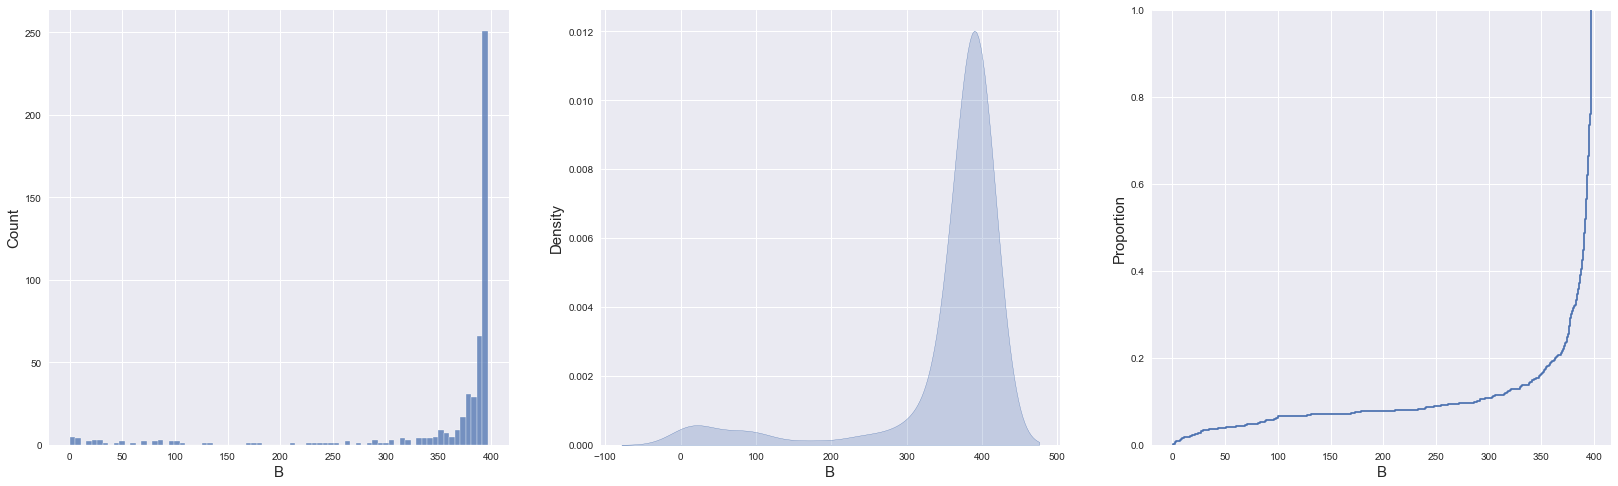

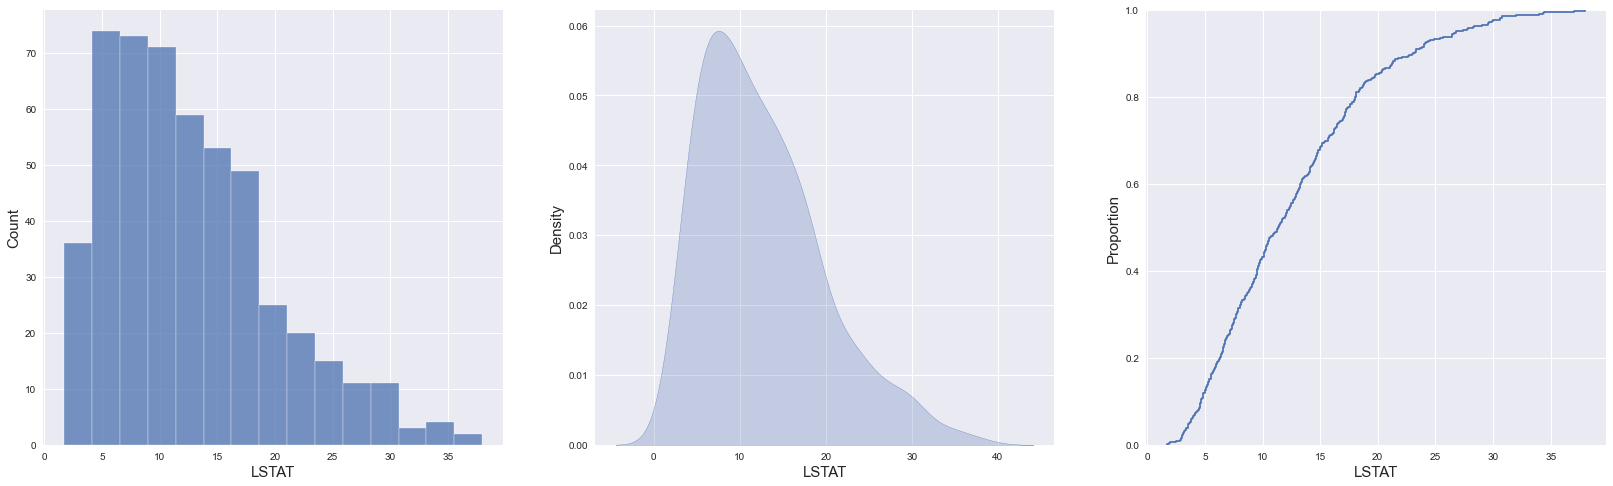

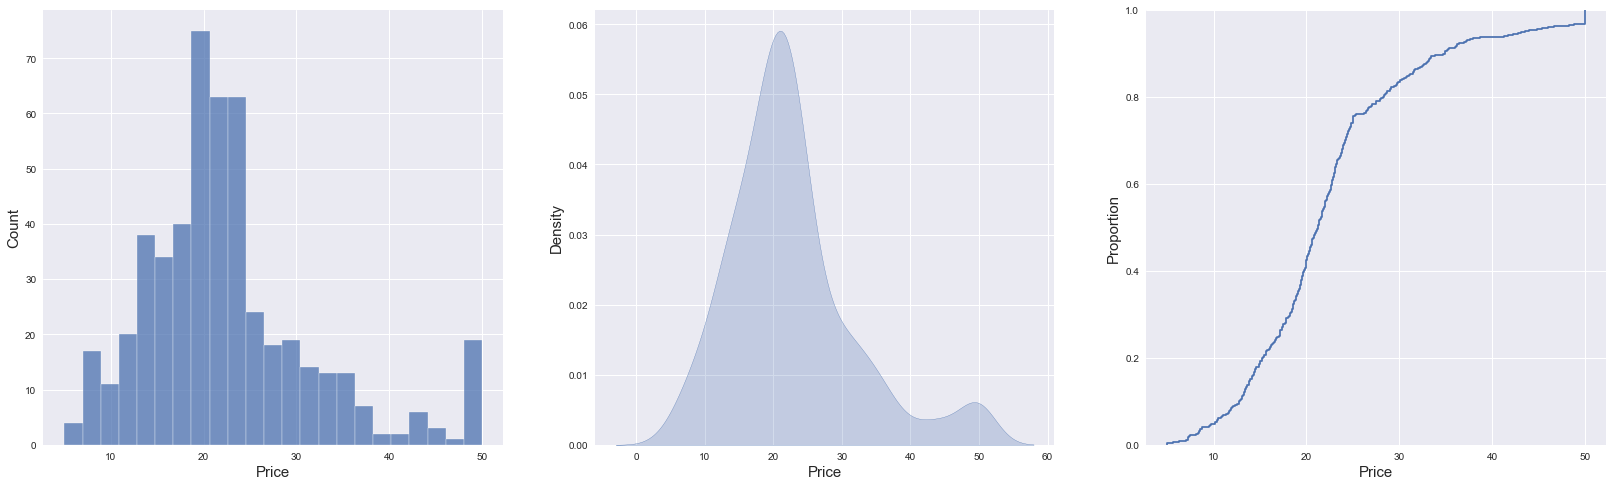

In [222]:
# check
univariate_plots(df)

## Correlation Analysis

### Correlation Table with Target

In [223]:
def corr_with_target(data, target_column):
    
    """
    
    This function will return correlation of each column with target
    
    """
    
    ### Extract Numeric Column
    numCols = extractNumCol(data)
    
    ### Save Data in Dict
    corr_dict = {}
    
    for nc in numCols:
        
        # Find a Correlation
        corr_val = data[nc].corr(data[target_column])
        
        # Add Column Name
        corr_dict[nc] = corr_val
    
    ### Build a Corr Table
    corr_table = pd.DataFrame(corr_dict.items(), columns=['Columns', target_column])
    
    ### Graphics
    plt.figure(figsize=(8, 12))
    heatmap = sns.heatmap(data.corr()[[target_column]].sort_values(by=target_column, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Features Correlating with Target - '+''+target_column, fontdict={'fontsize':18}, pad=16);
    
    corr_table = corr_table.set_index('Columns')
    return corr_table.T

Columns,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
Price,-0.388305,0.360445,-0.483725,0.17526,-0.427321,0.69536,-0.376955,0.249929,-0.381626,-0.468536,-0.507787,0.333461,-0.737663,1.0


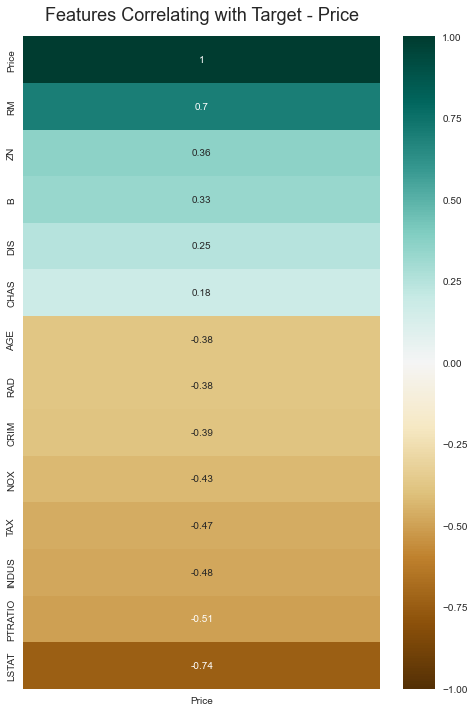

In [224]:
# check
corr_with_target(df, 'Price')

### Heatmap

In [225]:
def corr_heatmap(data):
    plt.figure(figsize=(16, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
    heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

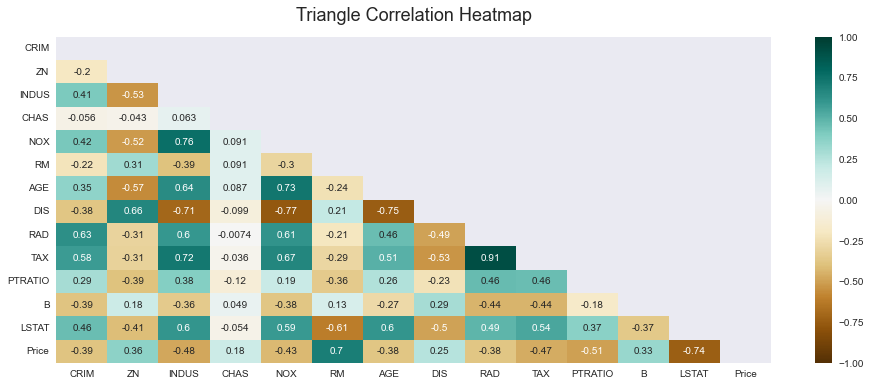

In [226]:
# check
corr_heatmap(df)

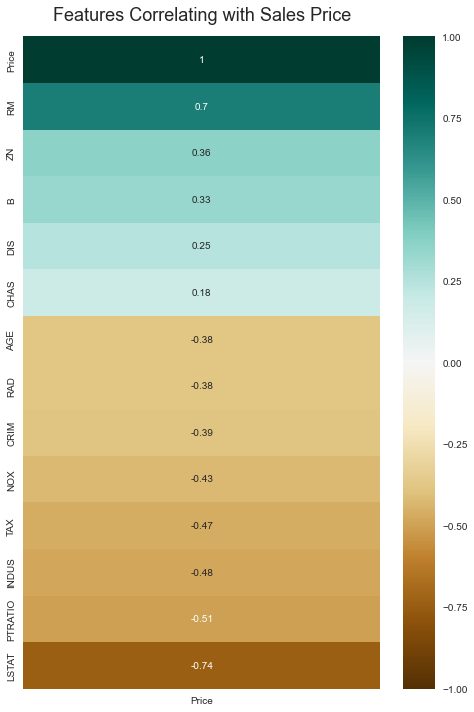

In [227]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

## Scatter Plot

In [228]:
def plot_scatter(data, target_column, num_col):
    
    # initialize plot counter
    count = 1
    
    # Set Grid
    fig = plt.figure(figsize=(15,60), constrained_layout = True)
    
    for i in df.columns.to_list():
        plt.subplot(len(data.columns), num_col, count)
        plt.scatter(data[i], data[target_column])
        plt.title('{}, subplot: {}{}{}'.format(i, len(data.columns), num_col, count))
        plt.xlabel(i)
        
        # Increment Counter
        count = count + 1
    
    ## Show
    plt.show()

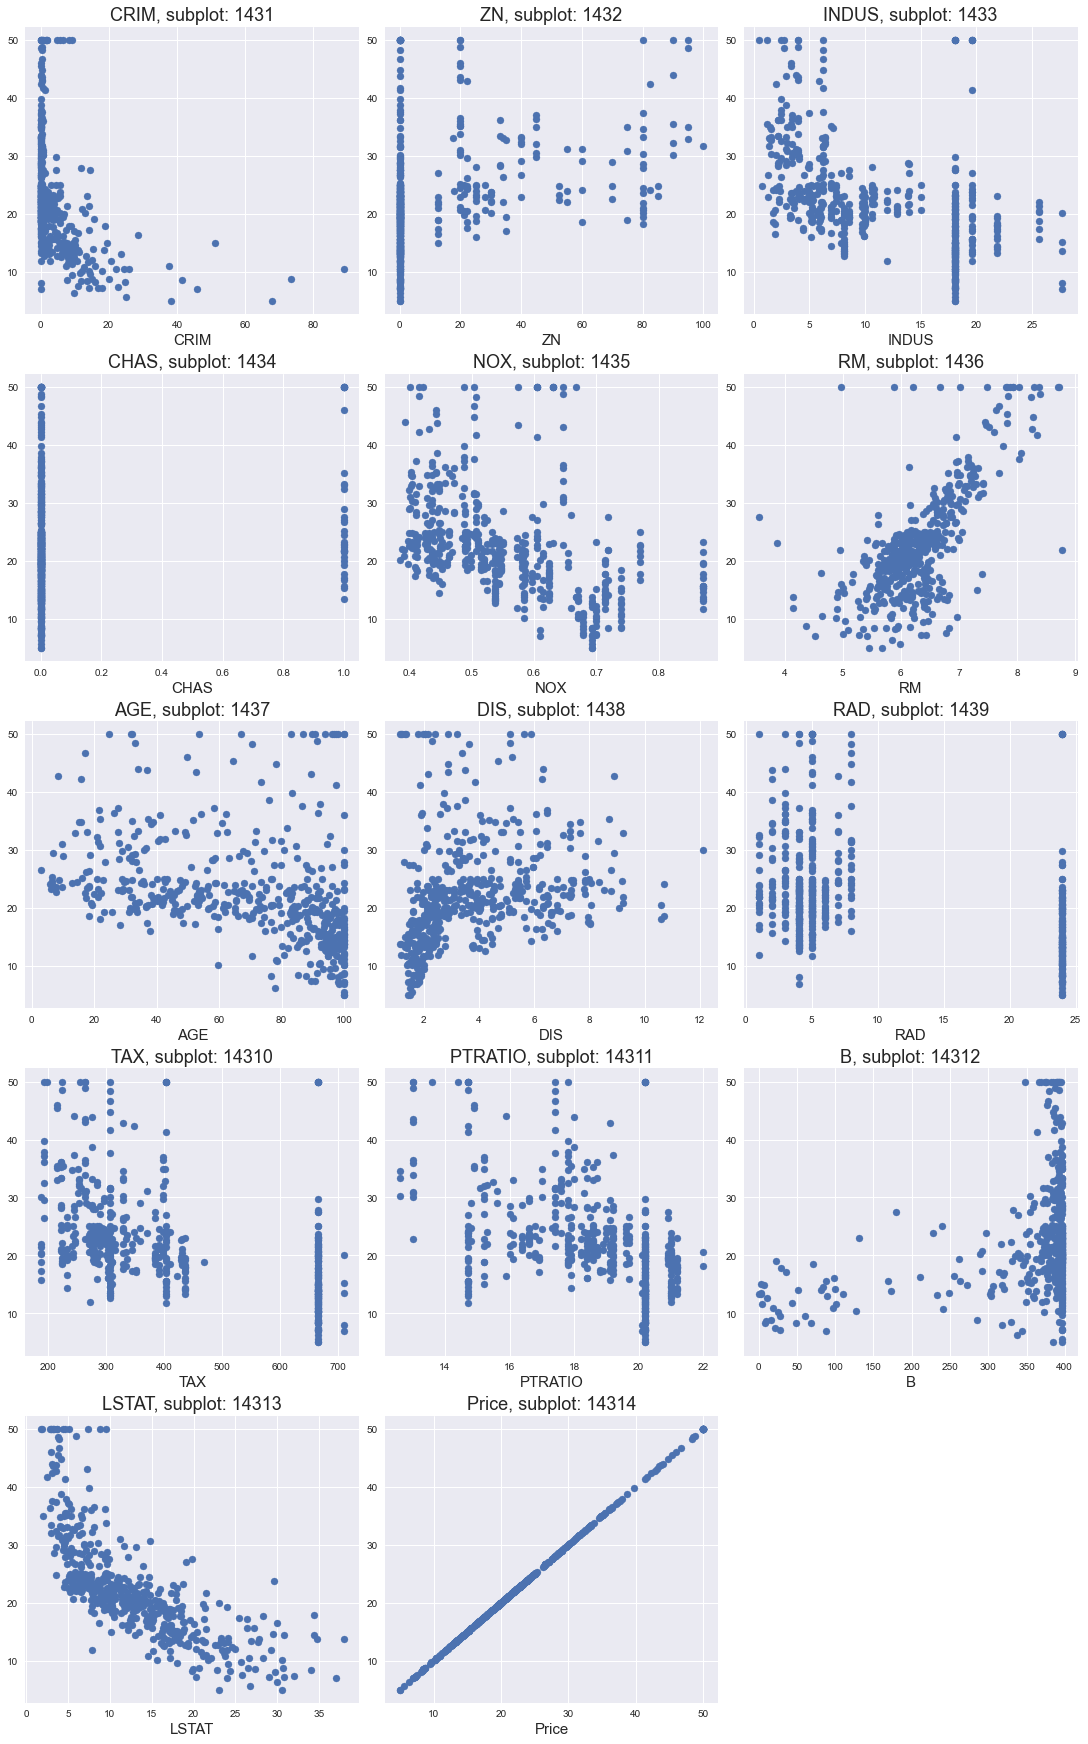

In [229]:
# check
plot_scatter(df, 'Price', 3)

# Data Prep for ML

## DV & IV

In [230]:
def break_dv_iv(data, target_column):
    
    ### Independent Variable
    iv = data.loc[:, ~data.columns.isin([target_column])]
    
    ### Dependent Variable
    dv = data[target_column].copy()
    
    return iv, dv

In [231]:
# check
iv, dv = break_dv_iv(df, 'Price')

In [232]:
iv.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [233]:
dv.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: Price, dtype: float64

## Train Test Split

In [234]:
def smart_split(data, test_size, target_col, random_state):
    """
    Split the data into train and test sets.
    """
    # Shuffle the data
    data = data.sample(frac=1, random_state=random_state)
    
    # Calculate the index for the split
    split_index = int(data.shape[0] * (1 - test_size))
    
    # Split the data
    X_train = data.iloc[:split_index, :-1]
    X_test = data.iloc[split_index:, :-1]
    y_train = data.iloc[:split_index, -1]
    y_test = data.iloc[split_index:, -1]
    
    return X_train, X_test, y_train, y_test

In [235]:
# check
X_train, X_test, y_train, y_test = smart_split(df, 0.3, 'Price', 42)

In [236]:
X_train.shape

(354, 13)

In [237]:
X_test.shape

(152, 13)

## Standardize Data

In [238]:
# def standardize(df):
#     """
#     Standardize the data in the DataFrame.
#     """
#     # Store the column names
#     col_names = df.columns
    
#     # Create a copy of the DataFrame
#     df_std = df.copy()
    
#     # Standardize the data
#     df_std = (df_std - df_std.mean()) / df_std.std()
    
#     # Set the column names
#     df_std.columns = col_names
    
#     return df_std.values

In [239]:
# def standardize_vec(vec):
#     # Subtract mean and divide by standard deviation
#     return (vec - vec.mean()) / vec.std()

In [240]:
## Standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

# Standadize X Train
X_train=scaler.fit_transform(X_train)

# Standardize X test
X_test=scaler.transform(X_test)

In [241]:
# Dump Pickle
pickle.dump(scaler,open('scaling.pkl','wb'))

In [242]:
X_train

array([[-0.39964024, -0.47799891, -1.03471691, ..., -0.87429662,
         0.42254243, -0.52196355],
       [-0.40332556,  1.18460598, -0.69498788, ..., -0.40592343,
         0.43803711, -1.27168797],
       [-0.39818446, -0.47799891,  2.37552907, ...,  0.76500954,
         0.3628879 ,  0.70671369],
       ...,
       [-0.38525873, -0.47799891, -0.09326445, ...,  0.06244976,
         0.41556982, -0.2593559 ],
       [-0.40281979,  0.35330354, -1.13836305, ..., -1.67053104,
         0.218566  , -1.34244237],
       [-0.40418588,  2.84721087, -1.09373763, ..., -0.96797125,
         0.39365592, -0.85804691]])

In [243]:
X_test

array([[ 0.72059889, -0.47799891,  0.98782239, ...,  0.81184686,
        -3.7159766 ,  1.75714428],
       [-0.40201056, -0.47799891, -1.30390897, ...,  0.10928708,
         0.43803711, -1.02676892],
       [-0.40760737,  3.2628621 , -1.0779028 , ..., -1.20215785,
         0.32116294, -1.32883575],
       ...,
       [-0.40764595,  2.84721087, -1.32838097, ..., -0.68694734,
         0.37207404, -0.93696527],
       [ 0.75461562, -0.47799891,  0.98782239, ...,  0.81184686,
        -2.73892619,  1.41425761],
       [-0.38535571, -0.47799891, -0.38548899, ...,  1.13970809,
        -3.17111715, -0.30561839]])

## Regression Plots

In [244]:
def reg_plots(train_df, test_df, y_train, y_train_pred, y_test, y_test_pred, random_search, X_data, y_data):
    
    
    # Create a figure and axis
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 10))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

    ### 1. Perfect Prediction
    ax1.set_title('Perfect Prediction with Regression Line')
    ax1.plot(y_train, y_train_pred, '.', label='Training')
    ax1.plot(y_test, y_test_pred, '.', label='Testing')
    
    # Plot the perfect prediction line
    x_min = min(y_train.min(), y_test.min())
    x_max = max(y_train.max(), y_test.max())
    ax1.plot([x_min, x_max], [x_min, x_max], '--k', label='Perfect Prediction')
    
    #Add the labels and legend
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.legend()
    
    ### 2. Training & Testing Error
    ax2.set_title('Training & Testing Error')
    sns.regplot(x='predicted', y='error', data=train_df, fit_reg=False, label='Training error', ax=ax2)
    sns.regplot(x='predicted', y='error', data=test_df, fit_reg=False, label='Testing error', ax=ax2)
    ax2.legend()
    
    ### 3. Distribution of Residuals
    ax3.set_title('Distribution of Residuals')
    sns.histplot(test_df['error'].values, label='Residuals', kde=True, ax=ax3)
    ax3.legend()
    
    ### 4. Scatterplot - Y Test Vs Y Pred
    sns.scatterplot(y_test, y_test_pred, ax=ax4)
    ax4.set_title("Predicted vs. Actual Values")
    ax4.set_xlabel("Actual Values")
    ax4.set_ylabel("Predicted Values")
    

    
    ### 5. Training & Testing Score with Alpha
    try:
        ax5.set_title('Training Score Vs Testing Score')
        ax5.plot(random_search.cv_results_['mean_train_score'], label='Training Score')
        ax5.plot(random_search.cv_results_['mean_test_score'], label='Testing Score')
        ax5.legend()

        ### 6. Scale - Location Plot to check Homoscedasticity
        """It’s good if you see a horizontal line with equally (randomly) spread points."""
        ax6.set_title('Scale Location Plot (Homoscedasticity)')
        ax6.plot(test_df['predicted'], np.sqrt(np.abs(test_df['error'])), 'o')
        ax6.set_xlabel('Fitted values')
        ax6.set_ylabel('Square root of absolute residuals')

        # Add a horizontal line at Middle
        # Calculate the middle of the y-axis
        y_middle = np.mean(np.sqrt(np.abs(test_df['error'])))
        ax5.axhline(y=y_middle, color='r', linestyle='-')

        ### 7. Learning Curve Plots
        # Calculate the training error and validation error for different training set sizes
        train_sizes, train_errors, val_errors = learning_curve(random_search, X_data, y_data)

        # Calculate the bias, variance, and total error for each training set size
        bias = np.mean(train_errors, axis=1) - np.mean(val_errors, axis=1)
        variance = np.var(val_errors, axis=1)
        error = np.mean(val_errors, axis=1)

        # Plot the bias, variance, and total error as a function of the training set size
        ax7.set_title('Bias Variance Tradeoff')
        ax7.plot(train_sizes, bias, label='Bias')
        ax7.plot(train_sizes, variance, label='Variance')
        ax7.plot(train_sizes, error, label='Total error')
        ax7.legend(loc='upper right')
        ax7.set_xlabel('Training set size')
        ax7.set_ylabel('Error')
        
        # Remove 8th & 9th Axes
        ax8.remove()
        ax9.remove()
        plt.tight_layout()
        plt.show()
        
    except:
        ax5.remove()
        ax6.remove()
        ax7.remove()
        ax8.remove()
        ax9.remove()
        plt.tight_layout()
        plt.show()

# ML (Machine Learning)

## Performance Measurement Function

In [245]:
def evaluate_regression_performance(y_test, y_pred):
    
    """
    Calculate various performance metrics for a linear regression model.
    
    Parameters:
    - y_test: a NumPy array of the true values of the dependent variable
    - y_pred: a NumPy array of the predicted values of the dependent variable
    - X_test: a NumPy array of the true values of the independent variable
    
    Returns:
    
    - mae: the mean absolute error of the model
    - mse: the mean squared error of the model
    - rmse: the root mean squared error of the model
    - mape: mape of the model
    - r2: the R-squared value of the model
    - adjusted r2: Adjusted R-squared value of the model
    - Explained Variance Score: returns the explained variance score as a float value between -inf and 1.
    
    """
    # Calculate the mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    
    # mape
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Explained Variance Score
    evs = explained_variance_score(y_test, y_pred)
    
    # Calculate the R-squared value
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R2
    n = len(y_test)
    y_pred_df = pd.DataFrame(y_pred)
    p = len(y_pred_df.columns)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return mae, mse, rmse, mape, evs, r2, adjusted_r2

## Linear Regression

In [246]:
def linear_regression(data, target_col, testSize, randomState):
    
    """
    Perform linear regression on the given data.
    
    Parameters:
    - data: Data with IV & DV
    - test_size: the proportion of the data to use for testing
    - target_column: Name of DV
    - random_state: the random seed for the train/test split (default is 42)
    
    Returns:
    - y_pred: a NumPy array of the predicted values of the dependent variable for the test set
    - mse: the mean squared error of the model
    - r2: the R-squared value of the model
    
    """
    
    ### 0. Save Data Here
    performance_metrics = {}
    
    ### 1. Data Disintegration (Data Should Be Model Ready FIRST)
    
    ## A. Break Data Into X and y
    X, y = break_dv_iv(data, target_col)
    
    ## B. Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=randomState)
    
    ### 2. Data Standardization
    
    ## A. X Train
    X_train = standardize(X_train)

    ## B. X Test
    X_test = standardize(X_test)
    
    
    ### 3. Model Building - Linear Regression
    
    ## A. Create a Object of Linear Regression Model
    reg_model = LinearRegression()
    
    ## B. Fitting a Linear Regression Model on Train Data
    reg_model.fit(X_train, y_train)
    
    ### 4. Performance Evaluation on Train Data
    
    ## A. Train Pred
    y_train_pred = reg_model.predict(X_train)
    
    ## B. Performance on Train Data
    train_performance = evaluate_regression_performance(y_train, y_train_pred)
    
    ### 5. Performance Evaluation on Test Data
    
    ## A. Test Pred
    y_test_pred = reg_model.predict(X_test)
    
    ## B. Performance on Test Data
    test_performance = evaluate_regression_performance(y_test, y_test_pred)
    
    ### 6. Performance Metrics DataFrame
    
    ## A. Append it to Dictionary
    performance_metrics['MAE'] = [train_performance[0], test_performance[0]]                   ### MAE
    performance_metrics['MSE'] = [train_performance[1], test_performance[1]]                   ### MSE
    performance_metrics['RMSE'] = [train_performance[2], test_performance[2]]                  ### RMSE
    performance_metrics['MAPE'] = [train_performance[3], test_performance[3]]                  ### MAPE
    performance_metrics['Explained Variance'] = [train_performance[4], test_performance[4]]    ### Explained Variance
    performance_metrics['R2'] = [train_performance[5], test_performance[5]]                    ### R2
    performance_metrics['Adjusted R2'] = [train_performance[6], test_performance[6]]           ### Adjusted R2
    
    ## B. Build a Performance Metrics DataFrame
    performance_metrics = pd.DataFrame(performance_metrics).T
    performance_metrics.columns = ['LR (Train)', 'LR (Test)']
    
    ### 7. Actual vs Predicted
    
    ## A. Calculate Errors
    train_error = y_train - y_train_pred
    test_error = y_test - y_test_pred
    
    ## B. AIO DataFrame
    train_df = pd.DataFrame({'actual': y_train, 'predicted': y_train_pred, 'error': train_error})
    test_df = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred, 'error': test_error})
    
    ### 8. Feature Coefficient | P Value | F-Score Table
    
    ## A. Calculate p-values and f-scores for each feature
    p_values = f_regression(X_train, y_train)[1]
    f_scores = f_regression(X_train, y_train)[0]
    
    ## B. Create DataFrame to hold feature coefficients, p-values, and f-scores
    feature_details = pd.DataFrame({'Coefficient': reg_model.coef_, 'P-Value': p_values, 'F-Score': f_scores}, index=X.columns)
    
    ### 9. Regression Plots
    reg_plots(train_df, test_df, y_train, y_train_pred, y_test, y_test_pred, reg_model, X, y)
    
    return performance_metrics, feature_details, reg_model

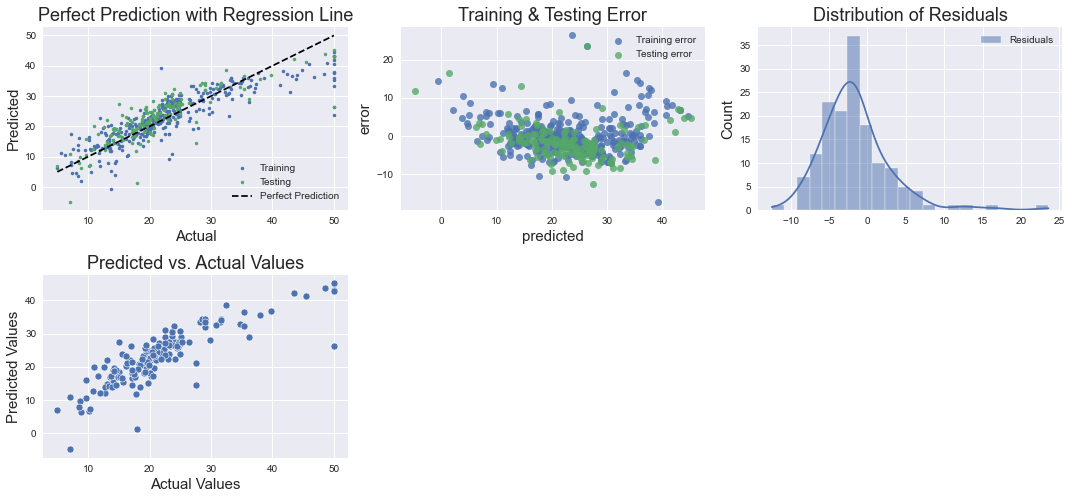

Wall time: 917 ms


In [247]:
%%time
metrics, feature_details , model = linear_regression(data=df, target_col='Price', testSize=0.3, randomState=42)

In [248]:
metrics

,LR (Train),LR (Test)
MAE,3.356827,3.743023
MSE,22.545481,24.106532
RMSE,4.748208,4.909840
MAPE,16.566130,19.951841
Explained Variance,0.743500,0.711177
R2,0.743500,0.676479
Adjusted R2,0.742771,0.674322


In [249]:
feature_details

,Coefficient,P-Value,F-Score
CRIM,-1.109915,1.230214e-13,59.572821
ZN,0.809584,2.064473e-10,42.878752
INDUS,0.343620,6.720704e-20,94.249230
CHAS,0.815016,1.690424e-05,19.032608
NOX,-1.800588,1.565186e-15,69.752049
RM,2.917982,4.275246e-53,335.351367
AGE,-0.299362,1.137517e-11,49.301500
DIS,-2.946676,4.380520e-06,21.767012
RAD,2.097157,6.223568e-14,61.144268
TAX,-1.449116,2.971814e-19,90.534912


In [250]:
model

LinearRegression()

## New Data Prediction

In [251]:
# Checking Prediction for New Data - For Example, we considered first row from data as new data
new_data = boston.data[0].reshape(1, -1)
new_data

array([[6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
        6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
        4.980e+00]])

In [271]:
boston.data[0].shape

(13,)

In [272]:
new_data.shape

(1, 13)

In [252]:
# Standadize New Data
std_data = scaler.transform(new_data)

# Predict
model.predict(std_data)

array([30.76376101])

In [204]:
# Save Standardization
#pickle.dump(standardize_vec, open('standardize.pkl', 'wb'))

## Pickling the Model (For Deployment)

In [253]:
# Import Pickle
import pickle

# Pickle Dump
pickle.dump(model,open('reg_model.pkl','wb'))

In [254]:
# Load Pickeld Model
pickled_model = pickle.load(open('reg_model.pkl','rb'))

In [255]:
# Let's perform prediction of first row / new_data using the pickled model
pickled_model.predict(std_data)

array([30.76376101])